In [1]:
# Uncomment and run if you do not have these packages installed or are outdated
#!pip install kemlglearn --upgrade
#!pip install scikit-learn --upgrade

# Prototype/Model Based Clustering

We are going to apply some of the model based clustering algorithms to the iris dataset and we will show also some of the shortcomings of the K-means algorithm

In [2]:
from sklearn import datasets
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from kemlglearn.cluster import Leader, KMedoidsFlexible
from kemlglearn.datasets import make_blobs
from numpy.random import normal
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## K-means

In [3]:
iris = datasets.load_iris()

We will play again with the iris dataset, now using K-means. In this case we will look for 3 clusters, as we actually know the number of classes.

CPU times: user 82.2 ms, sys: 782 µs, total: 83 ms
Wall time: 83.3 ms


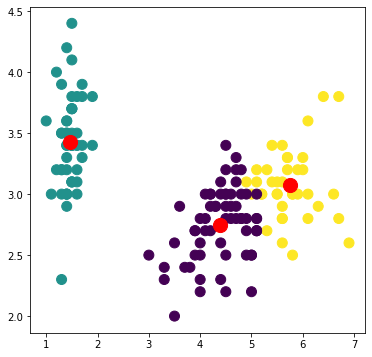

In [4]:
km = KMeans(n_clusters=3)
%time {km.fit(iris['data'])}
labels = km.predict(iris['data'])
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,2], km.cluster_centers_[:,1], c='r', s=200);

Results are a little bit worse than hierarchical clustering.

In [5]:
print(adjusted_mutual_info_score(iris['target'], labels))

0.7483723933229485


## K-medoids

CPU times: user 2.5 s, sys: 38.5 ms, total: 2.54 s
Wall time: 2.43 s


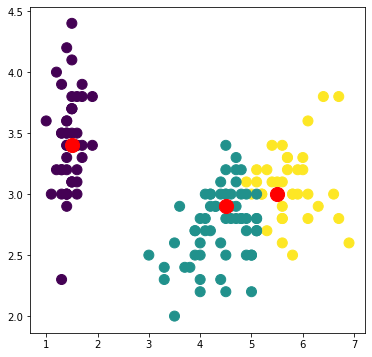

In [6]:
kmd = KMedoidsFlexible(n_clusters=3)
%time {kmd.fit(iris['data'])}
labels = kmd.predict(iris['data'])
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,2], kmd.cluster_medoids_[:,1], c='r', s=200);


In [7]:
print(adjusted_mutual_info_score(iris['target'], labels))

0.7483723933229484


## GMM

Now for Gaussian Mixture Models, first using spherical clusters as estimation method.

CPU times: user 4.2 ms, sys: 929 µs, total: 5.13 ms
Wall time: 4.81 ms


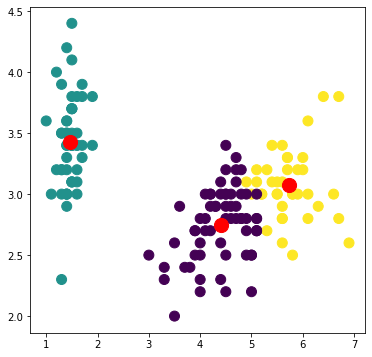

In [8]:
gmm = GaussianMixture(n_components=3, covariance_type='spherical')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100);
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [9]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.7483723933229485
BIC= 853.809340502941


As expected the results is comparable to the one from K-means.

Let's change the method of estimation assuming independent attributes (diagonal covariance).

CPU times: user 12.9 ms, sys: 1.17 ms, total: 14.1 ms
Wall time: 11.9 ms


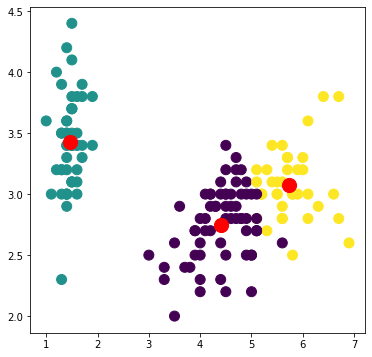

In [10]:
gmm = GaussianMixture(n_components=3, covariance_type='diag')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [11]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.7934250515435665
BIC= 744.6332089584272


Now we change to the full model, with dependent attributes

CPU times: user 27.3 ms, sys: 156 µs, total: 27.4 ms
Wall time: 25.4 ms


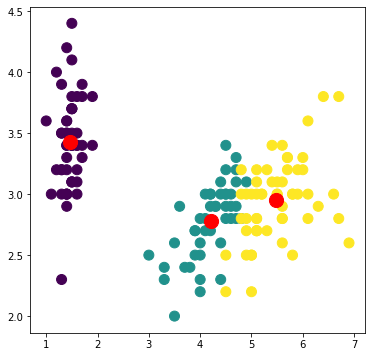

In [12]:
gmm = GaussianMixture(n_components=3, covariance_type='full')
%time {gmm.fit(iris['data'])}
labels = gmm.predict(iris['data'])
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,2], gmm.means_[:,1], c='r', s=200);

These are the results of the AMI and the final BIC of the model

In [13]:
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
print("BIC=", gmm.bic(iris['data']))

AMI= 0.8970537476260634
BIC= 580.8594247694391


This is now the **best model** we have found

## Leader Algorithm

Now we use the Leader Algorithm (from kemlglearn), the main problem is to guess a radius that results in the number of clusters we want and the quality could not be the best, the upside is that this algorithm is faster than the rest.

CPU times: user 51 ms, sys: 1.79 ms, total: 52.8 ms
Wall time: 47.4 ms
AMI= 0.7842528489695738


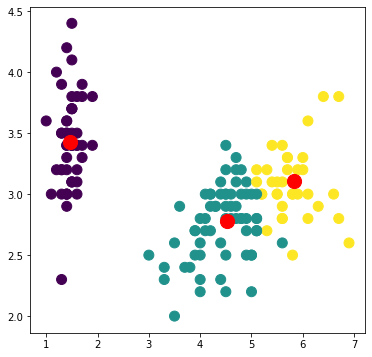

In [14]:
r=2.5
lead = Leader(radius=r)
%time {lead.fit(iris['data'])}
labels = lead.predict(iris['data'])
print("AMI=", adjusted_mutual_info_score(iris['target'], labels))
plt.figure(figsize=(6,6))
plt.scatter(iris['data'][:, 2], iris['data'][:, 1], c=labels, s=100)
plt.scatter(lead.cluster_centers_[:,2], lead.cluster_centers_[:,1], c='r', s=200);

## Issues with K-means

Now we will generate artificial data to see some issues of K-means. The first problem appears when the clusters have different sizes and variances. Depending on the ratio of sizes and variance difference, part of the examples from the larger cluster could be assigned to the small one.

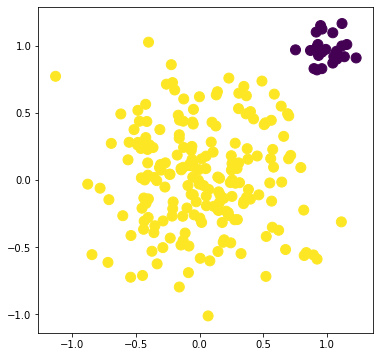

In [15]:
sc1=25
vc1=0.1
sc2=200
vc2=0.4

blobs, blabels = make_blobs(n_samples=[sc1,sc2], n_features=2, centers=[[1,1], [0,0]], cluster_std=[vc1,vc2])
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blabels, s=100);

AMI= 0.3295229366550898


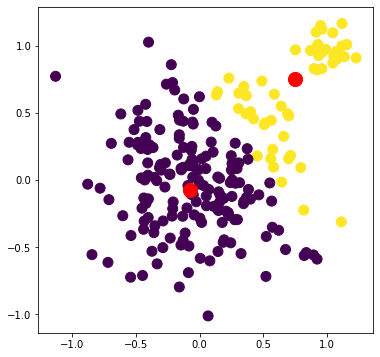

In [16]:
km = KMeans(n_clusters=2)
km.fit(blobs)
labels = km.fit_predict(blobs)
print("AMI=", adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(6,6))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,0], c='r', s=200);

AMI= 0.2928814577591342


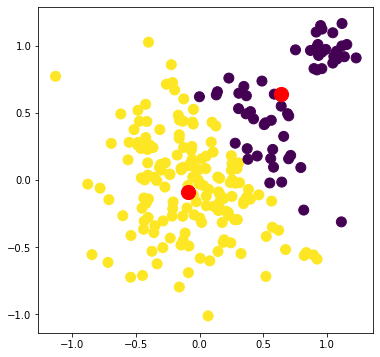

In [17]:
kmd = KMedoidsFlexible(n_clusters=2, max_iter=100)
kmd.fit(blobs)
labels = kmd.fit_predict(blobs)
print("AMI=", adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(6,6))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,0], kmd.cluster_medoids_[:,0], c='r', s=200);

This could affect less to the GMM algorithm, but it is not free of this problem.

AMI= 1.0


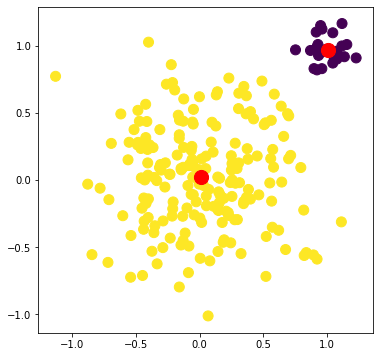

In [18]:
gmm = GaussianMixture(n_components=2, covariance_type='diag')
gmm.fit(blobs)
labels = gmm.predict(blobs)
print("AMI=",adjusted_mutual_info_score(blabels, labels))
plt.figure(figsize=(6,6))
plt.scatter(blobs[:, 0], blobs[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200);

Problems also appear when the clusters are not spherical and some attributes have more variance than others (actually are elipsoids). If the clusters are not well separated, the partition can result in not very natural clusters. You can change this data set and see what happens if you change the size, separation and variance of the clusters.

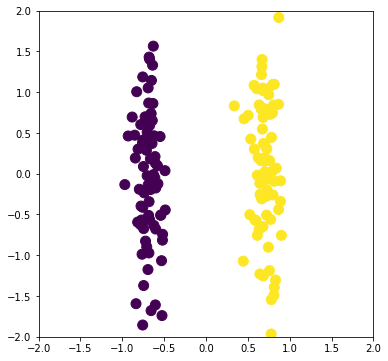

In [19]:
sc1=75
v1=0.1
sc2=75
v2=0.9

data = np.zeros((sc1+sc2,2))
data[0:sc1, 0] = normal(loc=-0.7, scale=v1, size=sc1)
data[0:sc1, 1] = normal(loc=0.0, scale=v2, size=sc1)
data[sc1:, 0] = normal(loc=0.7, scale=v1, size=sc2)
data[sc1:, 1] = normal(loc=0.0, scale=v2, size=sc2)
dlabels = np.zeros(sc1+sc2)
dlabels[sc1:] = 1
plt.figure(figsize=(6,6))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=dlabels, s=100);

K-means divides the two clusters wrong (sometimes depends on the initialization, you can use the random_state parameter of K-means to see if different initializations get it right)

AMI= 0.008234430265824053


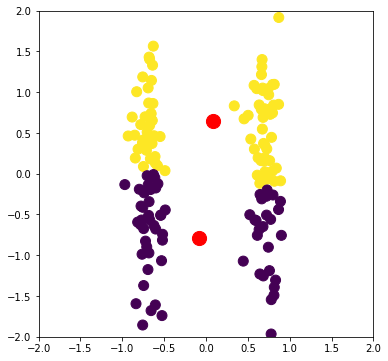

In [20]:
km = KMeans(n_clusters=2)
labels = km.fit_predict(data)
print("AMI=", adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(6,6))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='r', s=200);

As we can see, the K-means prototypes are completely out of the data densities, The advantage of K-medoids is that the cluster prototypes will be actual examples in the data, so there is a better chance that the algoritm will be more resilient to different variances if clusters are enough separated.

AMI= 1.0


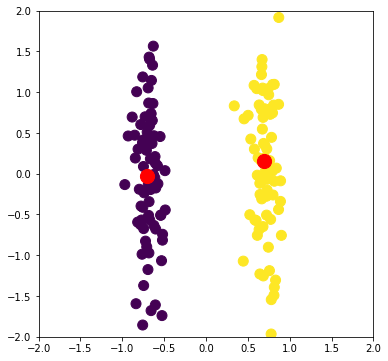

In [21]:
kmd = KMedoidsFlexible(n_clusters=2, max_iter=200)
labels = kmd.fit_predict(data)
print("AMI=", adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(6,6))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(kmd.cluster_medoids_[:,0], kmd.cluster_medoids_[:,1], c='r', s=200);

AMI= 1.0


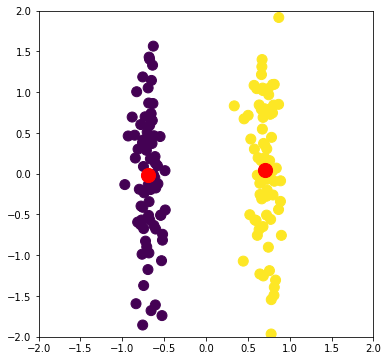

In [22]:
gmm = GaussianMixture(n_components=2, covariance_type='diag')
gmm.fit(data)
labels = gmm.predict(data)
print("AMI=",adjusted_mutual_info_score(dlabels, labels))
plt.figure(figsize=(6,6))
plt.ylim(-2,2)
plt.xlim(-2,2)
plt.scatter(data[:, 0], data[:, 1], c=labels, s=100)
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c='r', s=200);

The estimation of the parameters of the distribution done by GMM also has a better chance to be3 close to the data.

If you play with the characteristics of the dataset, you will see that usually if data are separated enough or the variances are different enough, clusters that have similar number of examples are partitioned right most of the time.